In [1]:
import pandas as pd 
import numpy as np
import time
from functools import partial
from glob import glob
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor
import xgboost as xgb

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from skopt import BayesSearchCV

from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression

C:\Users\nicol\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\nicol\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Bloco de código para importação dos dados

Feito pelo Felipe, vem do documento como usar.ipynb. E verificação dos dados obtidos.

In [2]:
# Importando bases

df_doenca_agg = pd.read_csv('../../../dados/com-clima/doenca_agrupado.csv', sep=';', dtype='str', low_memory=False)
df_doenca_agg['cod_muni'] = df_doenca_agg['cod_muni'].astype('int')
df_doenca_agg['ano'] = df_doenca_agg['ano'].astype('int')
df_doenca_agg['prevalencia'] = df_doenca_agg['prevalencia'].astype('float')
df_doenca_agg.set_index(['cod_muni', 'doenca', 'ano', 'estacao'], inplace=True)

df_doenca_dgg = pd.read_csv('../../../dados/com-clima/doenca_desagrupado.csv', sep=';', dtype='str', low_memory=False)
df_doenca_dgg['cod_muni'] = df_doenca_dgg['cod_muni'].astype('int')
df_doenca_dgg['ano'] = df_doenca_dgg['ano'].astype('int')
df_doenca_dgg['prevalencia'] = df_doenca_dgg['prevalencia'].astype('float')
df_doenca_dgg.set_index(['cod_muni', 'doenca', 'ano', 'estacao'], inplace=True)

df_clima = pd.read_csv('../../../dados/com-clima/clima.csv', sep=';', 
                       index_col=['cod_muni', 'ano', 'estacao'], low_memory=False)

df_censo_cs = pd.read_csv('../../../dados/com-clima/censo_com_selecao.csv', sep=';', 
                       index_col=['cod_muni'], low_memory=False)

df_censo_ss = pd.read_csv('../../../dados/com-clima/censo_sem_selecao.csv', sep=';', 
                       index_col=['cod_muni'], low_memory=False)

def pega_dados(agrupado=True, selecao=True, doenca=None, ano=None, estacao=None):
    '''
    Parametros
    - agrupado: se deve ou não pegar doencas com CID agrupado
    - selecao: se deve ou não pegar dados do Censo com selecao de colunas
    - doenca: se especificado pega somente entradas daquela doença
    - ano: se especificado pega somente as entradas daquele ano
    - estacao: se especificado pega somente entradas daquela estacao

    Retorna 2 dataframes, x e y, com dados de entrada e saida
    '''

    # tratando os parametros
    if agrupado:
        df_total = df_doenca_agg.copy()
    else:
        df_total = df_doenca_dgg.copy()
    df_total.reset_index(inplace=True)

    if doenca: 
        df_total = df_total[df_total['doenca'] == doenca]
    if ano: 
        df_total = df_total[df_total['ano'] == ano]
    if estacao: 
        df_total = df_total[df_total['estacao'] == estacao]

    df_total = pd.merge(df_total, df_clima, on=['cod_muni', 'ano', 'estacao'])
    
    if selecao:
        df_total = pd.merge(df_total, df_censo_cs, on=['cod_muni'])
    else:
        df_total = pd.merge(df_total, df_censo_ss, on=['cod_muni'])

    df_total.set_index(['cod_muni', 'doenca', 'ano', 'estacao'], inplace=True)
    df_total.dropna(inplace=True)

    # separando dataframe
    y = df_total[['prevalencia']]
    x = df_total.drop(columns=['prevalencia'])
    

    return x, y

In [3]:
doencas_dgg = df_doenca_dgg.reset_index()
lista_doencas_dgg = doencas_dgg['doenca'].unique()

In [4]:
len(lista_doencas_dgg)

1354

# Bloco principal de código do modelo

    Aqui fazemos em ordem  
     -Importação dos dados da doença específica    
     -Criação das variáveis de binarias de estação e das variaveis de município e ano  
     -Scalling da prevalência  
     -PCA (opcional)  
     -Split do dataset por data  
     -Treino do modelo  (escolher entre LGBM ou XGBM
     -Calculo das metricas utilizadas  
     -Print dos gráficos (opcional)  
     -E salvamos os resultados  
 
 Como usar: Apenas defina uma lista de doenças ou doença específica para colocar no for e comente ou não o bloco de código para geração dos gráficos.

(731, 100)
--- 1.6060283184051514 seconds --- 0


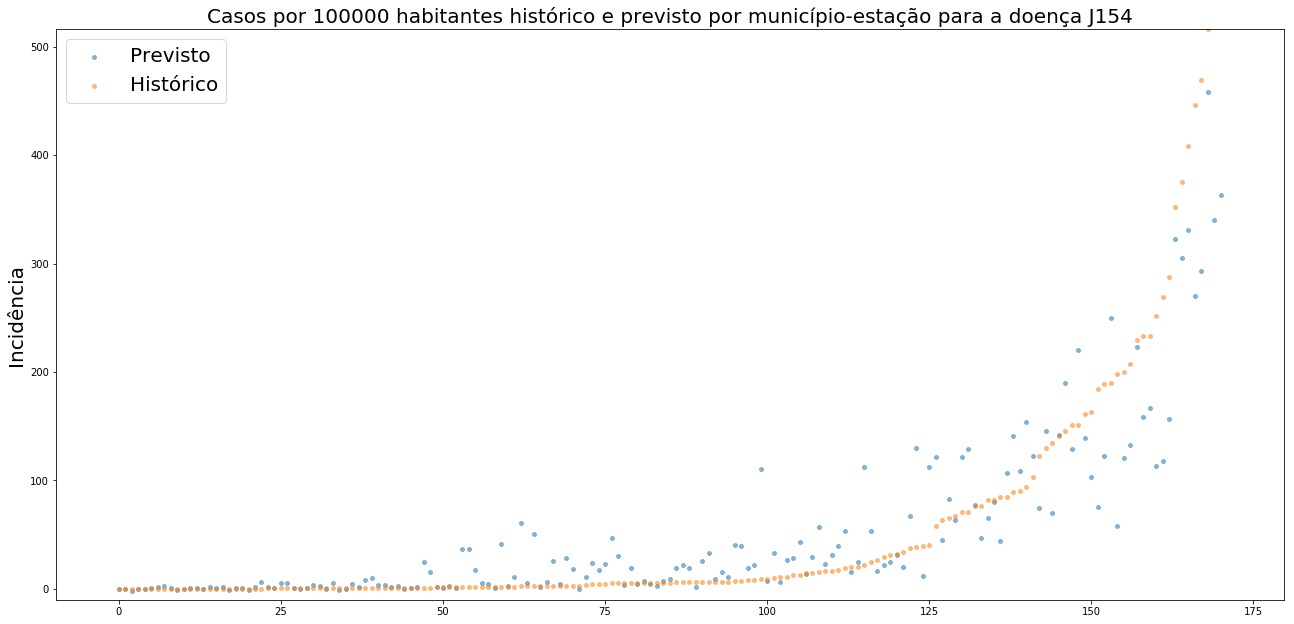

In [6]:
results_final = []
counter = 0
start_time = time.time()
novo_banco = []



for doenca in ['J154']: # lista_doencas_dgg:
    
    # Obtenção da doença especifica
    explicativas_completas, explicadas_completas = pega_dados(agrupado=False, selecao=True, doenca = doenca)
    explicativas_completas.reset_index(inplace = True)
    explicadas_completas.reset_index(inplace = True)
    print(explicativas_completas.shape)
    
    #Criação das variáveis de binarias de estação e das variaveis de município e ano
    
    explicativas_completas['bin_outono'] = np.zeros(len(explicativas_completas))
    explicativas_completas['bin_inverno'] = np.zeros(len(explicativas_completas))
    explicativas_completas['bin_verao'] = np.zeros(len(explicativas_completas))
    explicativas_completas['bin_primavera'] = np.zeros(len(explicativas_completas))
    
    explicativas_completas['municipio'] = explicativas_completas['cod_muni']
    explicativas_completas['ano_novo'] = explicativas_completas['ano']

    explicativas_completas.loc[explicativas_completas['estacao'] == 'O', 'bin_outono'] = 1
    explicativas_completas.loc[explicativas_completas['estacao'] == 'I', 'bin_inverno'] = 1
    explicativas_completas.loc[explicativas_completas['estacao'] == 'V', 'bin_verao'] = 1
    explicativas_completas.loc[explicativas_completas['estacao'] == 'P', 'bin_primavera'] = 1
    
    
    #Selecao de colunas corretas para as variaveis x e y e scalling
    
    x = explicativas_completas[explicativas_completas.columns[5:]].reset_index(drop = True)
    y = explicadas_completas['prevalencia'].reset_index(drop = True)
    
    novo_banco.append([doenca, len(y), explicadas_completas['prevalencia'].sum()])
    
    scalling_factor = np.max(y)
    y = y/np.max(y)
    
    #Transformação do PCA
    
    pca_components = 20
    
    x_censo = x[x.columns[:len(x.columns)-6]]
    #print(x_censo.head())
    x_estacao = x[x.columns[len(x.columns)-6:]]
    #print(x_estacao.head())
    
    if len(y) < pca_components:
        continue
    
    pca = PCA(pca_components)
    x_reduzidas = pca.fit_transform(x_censo)
    explained_variance = pca.explained_variance_ratio_.sum()
    
    x_reduzidas = pd.DataFrame(x_reduzidas)
    x_reduzidas = x_reduzidas.join(x_estacao)
    
    x_reduzidas = x
    
    # Train test split por data
    
    x_train = x_reduzidas[x_reduzidas['ano_novo'].isin(['2010', '2011', '2012', '2013'])]
    x_test = x_reduzidas[x_reduzidas['ano_novo'].isin(['2014'])]
    
    #print(x_train.shape)
    #print(x_test.shape)
    
    y_train = y.loc[x_train.index]
    y_test = y.loc[x_test.index]
    
    #print(y_train.shape)
    #print(y_test.shape)
    
    comparison_train = x_train.index == y_train.index
    #print(comparison_train.all())
    
    comparison_test = x_test.index == y_test.index
    #print(comparison_test.all())
    
    if len(y_test) < pca_components:
        continue
    
    # Fit do modelo e previsão XGBM
    
    optimised_XGBM = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, subsample = 0.7, learning_rate = 0.05, max_depth = 500,  n_estimators = 1000)
    optimised_XGBM.fit(x_train, y_train)
    
    y_predict = optimised_XGBM.predict(x_test)
    mean_y = np.ones(len(y_test))*np.mean(y_train)
    
    
    # Fit do modelo e previsão LGBM
    
    optimised_LGBM = LGBMRegressor(n_estimators = 3000, num_leaves = 1000, learning_rate = 0.01)
    optimised_LGBM.fit(x_train, y_train)
    
    y_predict = optimised_LGBM.predict(x_test)
    mean_y = np.ones(len(y_test))*np.mean(y_train)
    
    #Calculo do erro
    
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_predict))
    rmse_mean = np.sqrt(mean_squared_error(y_test, mean_y))
    ratio = rmse_rf/rmse_mean
    
    #Tempo de rodada
    
    if counter % 100 == 0:
        print("--- %s seconds ---" % (time.time() - start_time), counter)
        start_time = time.time()
    
    counter += 1
        
    #Bloco dos gráficos
    
    y_test = y_test.to_numpy()
    #y_predict = y_predict.to_numpy()
    
    n_habitantes = 10**5
    
    index = np.argsort(y_test)
    y_plot = y_test[index]*scalling_factor*n_habitantes
    y_predict = y_predict[index]*scalling_factor*n_habitantes
    mean_y = mean_y*scalling_factor*n_habitantes
    
    plt.clf()
    plt.scatter(np.arange(0, len(y_plot)), y_predict, label = 'Previsto', alpha=.5, s = 15)
    plt.scatter(np.arange(0, len(y_plot)), y_plot, label = 'Histórico', alpha=0.5, s = 15)
    
    #plt.plot(np.arange(0, len(y)), mean_y*scalling_factor, label = 'media')
    plt.legend(fontsize = 20)
    plt.title('Casos por 100000 habitantes histórico e previsto por município-estação para a doença ' + doenca, fontsize = 20)
    #plt.xlabel('Código do Município', fontsize = 15)
    plt.ylabel('Incidência', fontsize = 20)
    plt.ylim(-10, scalling_factor*0.8*n_habitantes)
    plt.gcf().set_size_inches(22, 10.5)
    plt.gcf().savefig('doença ' + doenca + '.png', dpi=100)
    #plt.xlim(len(y_plot)-500, len(y_plot))
    plt.savefig('grafico da doenca' + doenca + '.jpg')
    plt.show()
    
    # Salvando resultados obtidos
    
    results_final.append([doenca, rmse_rf, rmse_mean, ratio])
    

### Obtenção dos resultados

In [7]:
results_final = pd.DataFrame(results_final, columns = ['doenca', 'RMSE_RF', 'RMSE_mean', 'ratio' ])

results_final.sort_values(by = 'ratio', ascending = True, inplace = True)
results_final.reset_index(drop = True, inplace = True)
#results_final.to_csv('resultados LGBM todas as doencas acrescimo.csv')
results_final

doenca   RMSE_RF  RMSE_mean     ratio
0   J154  0.071808   0.170181  0.421952

### Obtenção do feature importance

(Suporta apenas 1 variavel e só para o LGBM atualmente)

In [8]:
data = pd.DataFrame({'Feature': x.columns, 'Value':optimised_LGBM.feature_importances_})
data.sort_values(by = 'Value', ascending = False)

NameError: name 'optimised_LGBM' is not defined